# ライブラリ

In [1]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve,recall_score, confusion_matrix, accuracy_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score
# import xgboost as xgb
import json
import pickle
import csv
import itertools
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
# import seaborn as sns
import warnings
warnings.simplefilter('ignore')
import os

In [2]:
plt.rcParams['font.family'] = 'Yu mincho'

# 入出力

In [3]:
# file_pred = data_path/'tmp/202012061919_all.csv'
file_f = 'bt_features.csv'
# file_input_score = 'C:/Users/nishina/workspace/keiba_y/keiba/resource/model_build/logs/wh/202012191641/202012191641_all.csv'
file_input_score = 'C:/Users/nishina/workspace/keiba_y/keiba/resource/model_build/logs/wh/20201219/score_all.csv'

# 読み込み

## 三連複オッズ

In [4]:
file_sanrenpuku_odds = '../../../resource/common/raw_result/odds/sanrenpuku_odds.csv'

def parse_sanrenpuku(file_sanrenpuku_odds):
    df_sanrenpuku = pd.read_csv(file_sanrenpuku_odds, index_col=0)
    df_sanrenpuku.reset_index(drop=True, inplace=True)
    df_sanrenpuku.drop('選択', axis=1, inplace=True)

    df_sanrenpuku = df_sanrenpuku.loc[df_sanrenpuku.オッズ!='---.-']

    tmp = df_sanrenpuku['組み合わせ'].str.replace('  ', ' ').str.split(' ', expand=True)
    tmp.columns = ['馬1', '馬2', '馬3']

    for col in tmp.columns:
        tmp[col] = tmp[col].astype(int).astype(str).str.zfill(2)

    df_sanrenpuku = pd.concat([df_sanrenpuku, tmp], axis=1)

    df_sanrenpuku['三連複_key'] = df_sanrenpuku.race_id.astype(str) + df_sanrenpuku['馬1'] + df_sanrenpuku['馬2'] + df_sanrenpuku['馬3']

    df_sanrenpuku.オッズ = df_sanrenpuku.オッズ.astype(float)
    return df_sanrenpuku

In [5]:
df_sanrenpuku = parse_sanrenpuku(file_sanrenpuku_odds)

In [6]:
df_sanrenpuku.head(2)

,組み合わせ,オッズ,race_id,馬1,馬2,馬3,三連複_key
0,1 2 3,340.5,201209030111,01,02,03,201209030111010203
1,1 2 4,907.1,201209030111,01,02,04,201209030111010204


## race_master

In [7]:
file_race_master = '../../../resource/common/race_info_master.csv'
df_info = pd.read_csv(
    file_race_master,
    usecols=['condition_int', 'weather_int', 'race_id', 'race_date', 'race_class_prize']
).set_index('race_id')
df_info.race_date = pd.to_datetime(df_info.race_date)
print(df_info.shape)
df_info.head(2)

(27125, 4)


,race_date,race_class_prize,condition_int,weather_int
race_id,,,,
201001020110,2010-09-11,オープン,1,2
201001020111,2010-09-11,2勝クラス,1,2


## race_transaction

In [8]:
file_race_transaction = '../../../resource/common/race_result_transaction.csv'
df_result = pd.read_csv(file_race_transaction, usecols=['race_id', '馬名', 'odds', 'horse_id', 'course_num'])
print(df_result.shape)
df_result.head(2)

(387828, 5)


,course_num,馬名,odds,race_id,horse_id
0,3,マイネルギブソン,6.0,201001020110,1
1,10,ロビンフット,2.7,201001020110,2


## wh_score

In [9]:
df_pred = pd.read_csv(file_input_score, engine='python', encoding='cp932')
df_pred.head(2)

,arrival,horse_id,race_id,pred_prob
0,8,13840,201201010101,0.116094
1,1,3734,201201010101,0.541489


# 特徴量作成

## 関数

In [10]:
def add_ss(df_pred):
    data_list = []
    for k,v in df_pred.groupby('race_id'):
        ss = pd.DataFrame(StandardScaler().fit_transform(v[['pred_prob']]), columns=['pred_ss'])
        tmp_data = pd.concat([
            v.reset_index(drop=True),
            ss.reset_index(drop=True)
        ], axis=1)
        data_list.append(tmp_data)

    df_pred = pd.concat(data_list)
    return df_pred

In [11]:
def get_rank(df_pred):
    df_pred['pred_rank'] = df_pred.groupby('race_id').pred_prob.rank(ascending=False, method='min')
    df_pred['odds_rank'] = df_pred.groupby('race_id').odds.rank(ascending=True, method='min')
    return df_pred

In [12]:
def get_pivot(df_pred, value_col, colname=None, n=3):
    if colname is None:
        colname = value_col
    pivot = pd.pivot_table(
        df_pred,
        values=value_col,
        index='race_id',
        columns='pred_rank'
    )
    pivot.columns = [f'{colname}{i}' for i in range(1,n+1)]
    return pivot

In [20]:
def _make_buy(df_pred):
    set_list = list(itertools.combinations(range(1,6), 3))
    df_list = []
    for use_set in set_list:
#         print(use_set)
        df_tmp = df_pred.query('pred_rank in @use_set').rename(columns={
            'pred_prob': 'score',
            'pred_ss': 'score_ss',
            'course_num': 'cn',
            'odds': 'odds'
        })
        num = len(use_set)
        
        tmp_all = pd.concat([
            get_pivot(df_tmp, col) for col in ['score', 'score_ss', 'cn', 'odds']
        ], axis=1)
        tmp_all['pat'] = str(use_set[0]) + str(use_set[1]) + str(use_set[2])
        
        df_tmp.sort_values(['race_id', 'cn'], inplace=True)
        for k,v in df_tmp.groupby('race_id'):
            key = str(k) + v.cn.astype(str).str.zfill(2).sum()
            tmp_all.loc[k, '三連複_key'] = key

        df_list.append(tmp_all)
    return pd.concat(df_list).reset_index()

In [31]:
def make_buy(df_pred):
    df_list = []
    df_tmp = df_pred.query('pred_rank <= 6').rename(columns={
        'pred_prob': 'score',
        'pred_ss': 'score_ss',
        'course_num': 'cn',
        'odds': 'odds'
    })

    tmp_all = pd.concat([
        get_pivot(df_tmp, col, n=6) for col in ['score', 'score_ss', 'cn', 'odds']
    ], axis=1)
    
    return tmp_all

In [36]:
def add_sdiff(df):
    for comb in list(itertools.combinations(range(1,7), 2)):
        col = f's_diff_{comb[0]}{comb[1]}'
        s0_col = f'score{comb[0]}'
        s1_col = f'score{comb[1]}'
        df[col] = df[s1_col] - df[s0_col]
    return df

In [64]:
def parse_cn(ser):
    return ser.astype(int).astype(str).str.zfill(2)

In [65]:
def merge_odds(df_ac, df_sanrenpuku):
    df_ac = df_ac.merge(
        df_sanrenpuku[['三連複_key', 'オッズ']],
        how='left',
        on='三連複_key'
    ).rename(columns={'オッズ':'三連複_odds'})
    return df_ac

In [66]:
def parse_sanrenpuku(file_srp_odds):
    df_srp = pd.read_csv(file_srp_odds, index_col=0)
    df_srp.reset_index(drop=True, inplace=True)
    df_srp.drop('選択', axis=1, inplace=True)

    df_srp = df_srp.loc[df_srp.オッズ!='---.-']

    tmp = df_srp['組み合わせ'].str.replace('  ', ' ').str.split(' ', expand=True)
    tmp.columns = ['馬1', '馬2', '馬3']

    for col in tmp.columns:
        tmp[col] = parse_cn(tmp[col])

    df_srp = pd.concat([df_srp, tmp], axis=1)

    df_srp['三連複_key'] = df_srp.race_id.astype(str) + df_srp['馬1'] + df_srp['馬2'] + df_srp['馬3']

    df_srp.オッズ = df_srp.オッズ.astype(float)
    return df_srp
#     df_srp.to_csv(file_srp_odds_parsed, index=False)

In [67]:
def get_acc_ids(df_pred):
    acc_list = []
    double_list = []
    for k,v in df_pred.query('arrival <= 3').groupby('race_id'):
        if len(v)>3:
            key = str(k) + v.drop_duplicates('arrival', keep='first').sort_values('course_num').course_num.astype(str).str.zfill(2).sum()
            double_list.append(key)
            key = str(k) + v.drop_duplicates('arrival', keep='last').sort_values('course_num').course_num.astype(str).str.zfill(2).sum()
            double_list.append(key)   
        else:
            key = str(k) + v.sort_values('course_num').course_num.astype(str).str.zfill(2).sum()
            acc_list.append(key)
    return acc_list + double_list

In [68]:
def add_pat_key(df_pat, comb):
    cols = [f'cn{i}' for i in comb]
    df_pat['三連複_key'] = (
        df_pat.index.astype(str)
        + parse_cn(df_pat[cols].min(axis=1))
        + parse_cn(df_pat[cols].median(axis=1))
        + parse_cn(df_pat[cols].max(axis=1))
    )
    return df_pat

In [69]:
def get_features(df_pat, comb):
    df_pat['ss_mean'] = df_pat[[f'score_ss{i}' for i in comb]].mean(axis=1)
    df_pat['score_sum'] = df_pat[[f'score{i}' for i in comb]].sum(axis=1)

    df_pat['score_rate'] = df_pat.score_sum / df_pat.score_allsum
    df_pat['score_diff'] = df_pat.score_allsum - df_pat.score_sum
    return df_pat

In [ ]:
def make_


## 買い目pivot

In [70]:
df_pred = pd.read_csv(file_input_score, engine='python', encoding='cp932')
df_pred =sum = df_pred.groupby('race_id'

sum.columns = ['score_allsum']

f_ac.merge(score_allsum, how='l
= get_acc_ids(df_pred)
 {}
in list(itertools.combinations(
t = df_ac.copy()
 str(comb[0]) + str(comb[1]) + 
t['pat'] = pat
 df_pred.merge(df_result, how='left', on=['race_id', 'horse_id'])
df_pred = add_ss(df_pred)
df_pred = get_rank(df_pred)
df_ac = make_buy(df_pred)
df_ac = add_sdiff(df_ac)

df_ac = df_ac.merge(df_info, how='left', on='race_id')
df_ac['race_date'] = df_ac.race_date.dt.week

score_allsum = df_pred.groupby('race_id').pred_prob.sum().to_frame()
score_allsum.columns = ['score_allsum']
df_ac = df_ac.merge(score_allsum, how='left', on='race_id')
acc_list = get_acc_ids(df_pred)
df_dict = {}
for comb in list(itertools.combinations(range(1,6), 3)):
    df_pat = df_ac.copy()
    pat = str(comb[0]) + str(comb[1]) + str(comb[2])
    df_pat['pat'] = pat
    df_pat = add_pat_key(df_pat, comb)
    df_pat = merge_odds(df_pat, df                      _sanrenpuku)
    df_pat = get_features(df_pat, comb)
    df_pat['三連複'] = 0
    df_pat.loc[df_pat.三連複_key.isin(acc_list), '三連複'] = 1
    df_pat = pd.get_dummies(df_pat, columns=['race_class_prize', 'condition_int', 'weather_int'])
    df_dict[pat] = df_pat



In [ ]:
df_pat_all = pd.concat(df_dict.values())

In [72]:
tmp = pd.crosstab(df_pat_all.pat, df_pat_all.三連複, margins=True)
tmp['rate'] = tmp[1] / tmp.All
tmp

三連複,0,1,All,rate
pat,,,,
123,8642,535,9177,0.058298
124,8773,404,9177,0.044023
125,8862,315,9177,0.034325
134,8881,296,9177,0.032255
135,8943,234,9177,0.025499
145,9001,176,9177,0.019178
234,8979,198,9177,0.021576
235,9013,164,9177,0.017871
245,9067,110,9177,0.011986


## 週クラスター

In [97]:
from sklearn.cluster import KMeans

In [102]:
df_cnt = pd.pivot_table(
    df_pat_all,
    index='race_date',
    columns='pat',
    values='三連複',
    aggfunc='sum'
)

In [105]:
df_cnt['cnt'] = df_ac.race_date.value_counts()
df_rate = df_cnt.div(df_cnt.cnt, axis=0)

In [106]:
df_rate

pat,123,124,125,134,135,145,234,235,245,345,cnt
race_date,,,,,,,,,,,
1,0.076923,0.000000,0.012821,0.038462,0.012821,0.038462,0.025641,0.000000,0.025641,0.012821,1.0
2,0.039683,0.015873,0.039683,0.023810,0.007937,0.015873,0.015873,0.007937,0.007937,0.023810,1.0
3,0.030675,0.036810,0.024540,0.049080,0.006135,0.012270,0.006135,0.018405,0.012270,0.000000,1.0
4,0.074830,0.074830,0.040816,0.020408,0.027211,0.027211,0.020408,0.020408,0.013605,0.006803,1.0
5,0.073394,0.045872,0.027523,0.073394,0.027523,0.018349,0.027523,0.009174,0.000000,0.018349,1.0
6,0.037037,0.014815,0.029630,0.022222,0.044444,0.007407,0.037037,0.014815,0.014815,0.029630,1.0
7,0.021505,0.059140,0.032258,0.037634,0.026882,0.021505,0.043011,0.021505,0.010753,0.016129,1.0
8,0.083333,0.050000,0.016667,0.022222,0.016667,0.022222,0.016667,0.000000,0.016667,0.000000,1.0
9,0.066667,0.050000,0.038889,0.033333,0.033333,0.022222,0.033333,0.016667,0.005556,0.011111,1.0


# model

## 関数

In [73]:
def get_balanced_data(df, target_col):
    s_rate = (df[target_col] == 1).sum() / df.shape[0]
    df_train, df_test = train_test_split(df, test_size=int(df.shape[0]*s_rate*0.7), random_state=0, stratify=df[target_col])
    if  s_rate > 0.4:
        return s_rate, df_train, df_test
    # 不均衡データ調整
    target_size = (df_train[target_col]==1).sum()

    df_train_0 = df_train[df_train[target_col]==0]
    df_train_use = df_train_0.sample(target_size, random_state=0)
    df_train_use = pd.concat([df_train_use, df_train[df_train[target_col]==1]])

    tmp = df_train_use[[target_col]]
    tmp['種類'] = 'train'
    tmp2 = df_test[[target_col]]
    tmp2['種類'] = 'test'
    tmp3 = pd.concat([tmp, tmp2])
    df_sampling = pd.crosstab(tmp3.種類, tmp3[target_col], margins=True)
    display(df_sampling)

    s_rate = df_test[target_col].sum() / len(df_test[target_col])
    return s_rate, df_train, df_test

In [74]:
def plot_calibration(y_test, prob2, filename=None):
    prob_true, prob_pred = calibration_curve(y_true=y_test, y_prob=prob2, n_bins=20)

    fig, ax1 = plt.subplots()
    ax1.plot(prob_pred, prob_true, marker='s', label='calibration plot', color='skyblue')
    ax1.plot([0, 1], [0, 1], linestyle='--', label='ideal', color='limegreen')
    ax1.legend(bbox_to_anchor=(1.12, 1), loc='upper left')
    ax2 = ax1.twinx()
    ax2.hist(prob2, bins=20, histtype='step', color='orangered')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('score')
    ax2.set_ylabel('frequency')
    if not filename is None:
        fig.savefig(filename, bbox_inches='tight', pad_inche=.05)
    plt.show()
    plt.clf()

In [75]:
def get_return(df, pred_col, odds_col, hue_col, vmax=1, step=0.01, over=True, plot_min=0.8):
    df_ret = pd.DataFrame(columns=['対象数', '回収率'])
    if over:
        op = '>'
    else:
        op = '<'
    max_ret = -10000
    max_th = -1
    max_len = -1
    for th in np.arange(0, vmax, step):
        th = round(th, 4)
        tmp = df.query(pred_col + op + str(th))
        ret = round((tmp.query(hue_col+'==1')[odds_col].sum()/tmp.shape[0]), 4)
        if ret > max_ret:
            max_ret = ret
            max_th = th
            max_len = len(tmp)
        df_ret.loc[th] = [tmp.shape[0], ret]
    print(f'対象カラム: {pred_col}, 最大回収率: {max_ret}, 閾値: {max_th}, 対象数: {max_len}, 対象率: {round(max_len/df.shape[0], 3)}')
    
    df_ret['対象率'] = df_ret.対象数 / df.shape[0]
    
#     plt.scatter(max_th, max_ret, s=100, c='none', edgecolors='blue')
    df_ret.回収率.plot()
    plt.plot([0,vmax], [1,1])
    plt.ylim(plot_min, )
    plt.ylabel('回収率')
    plt.xlabel(pred_col)
    plt.twinx()
    df[pred_col].hist(bins=20, alpha=.1, color='c', grid=False, range=(0, vmax))
    plt.ylabel('件数')
    plt.show()
    return df_ret, max_th

利用できるモデル  
- 馬連
  - AUC 0.744
  - 回収率 1.5くらい(EV 0.6)
- ワイド
  - AUC 0.713
  - 回収率 1.25くらい(EV 0.5)
- 三連複
  - AUC 0.770
  - 回収率 1.5くらい(EV 0.5)
  - 回収率 2くらい(EV 0.75)
- 三連単
  - AUC 0.788
  - 回収率 1.5くらい(EV 0.5)
  - 回収率 2くらい(EV 0.75)

利用できないモデル  
- 単勝
  - 馬モデルが要変更
- 複勝
  - 正確なオッズ入手により変わるかも
- 馬単
  - EVに対する回収率が安定しない

In [107]:
def get_wk(col, n=4):
    km = KMeans(
        n_clusters=n,
        init='k-means++',
        n_init=10,
        max_iter=300,
        tol=0.0001,
        precompute_distances='auto',
        verbose=0,
        random_state=0,
    #     copy_x=True,
    #     n_jobs=1
    )
#     name = col + '_label'
    name = 'label'
    df_rate[name] = km.fit_predict(df_rate[[col]])
    return df_rate[[name]], km

In [77]:
import pathlib
resource_path = pathlib.Path('../../../resource')
model_path = resource_path /'common/model/BettingTicket'
def output_model(model, target_col, y_test, prob2, s_rate, X_cols):
    log_path = model_path / target_col
    os.makedirs(log_path/'image', exist_ok=True)
    pickle.dump(model,open(log_path/'model.pickle', 'wb'))

    plot_calibration(y_test, prob2, log_path/'image/calibration_plot.png')
#     plot_roc(y_test, prob2, log_path/'image/roc_plot.png')
    with open(log_path/'model_config.json', 'w') as f:
        json.dump({
                'X_cols':X_cols,
                'target_col': target_col,
                'params': model.get_params(),
                's_rate': s_rate,
                'AUC': roc_auc_score(y_test, prob2)
            },
            f,
            indent=4
        )

## 閾値を見る

In [223]:
pred_dict = {}
km_dict = {}

In [149]:
df_th = pd.DataFrame(columns=['ret100_th', 'ret100_rate','ret120_th', 'ret120_rate','ret150_th', 'ret150_rate', 'ret170_th', 'ret170_rate'])

In [150]:
print('オッズ')
print(df_pat_all.三連複_odds.describe())
print()
print('3シグマ: ', df_pat_all.三連複_odds.mean() + (df_pat_all.三連複_odds.std() * 3))
print('全部買った時の回収率: ', df_pat_all.query('三連複==1').三連複_odds.sum() / df_pat_all.shape[0])

オッズ
count    90360.000000
mean       114.513817
std        302.577121
min         -3.000000
25%         23.500000
50%         48.800000
75%        109.300000
max      34527.000000
Name: 三連複_odds, dtype: float64

3シグマ:  1022.2451803187178
全部買った時の回収率:  0.8249482401656315


### 123

In [226]:
X_cols = [
    'score1',
    'score2',
    'score3',
    'score4',
    'score5',
    'score6',
    'score_ss1',
    'score_ss2',
    'score_ss3',
    'score_ss4',
    'score_ss5',
    'score_ss6',
    'odds1',
    'odds2',
    'odds3',
#     'odds4',
#     'odds5',
#     'odds6',
#     's_diff_12',
#     's_diff_13',
    's_diff_14',
    's_diff_15',
    's_diff_16',
    's_diff_23',
    's_diff_24',
#     's_diff_25',
#     's_diff_26',
    's_diff_34',
    's_diff_35',
#     's_diff_36',
#     's_diff_45',
#     's_diff_46',
#     's_diff_56',
#     'race_date',
#  'score_allsum',
#     '三連複_odds',
    'ss_mean',
    'score_sum',
    'score_rate',
    'score_diff',
    'race_class_prize_1勝クラス',
    'race_class_prize_2勝クラス',
    'race_class_prize_3勝クラス',
    'race_class_prize_未勝利',
    'condition_int_1',
    'condition_int_2',
    'condition_int_3',
    'weather_int_1',
    'weather_int_2',
    'weather_int_3',
    'label_0', 
    'label_1',
    'label_2',
    'label_3'
]

----------------------------------------
三連複 三連複_odds


,0
score1,0.352846
score2,0.331056
score3,0.112178
score4,-0.028058
score5,-0.162224
score6,-0.148172
score_ss1,-0.111520
score_ss2,0.054252
score_ss3,-0.063051
score_ss4,0.247480


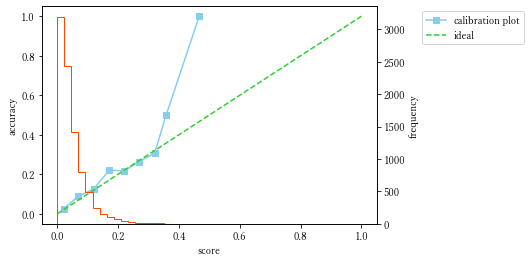

AUC 0.7180619286772411
対象カラム: 三連複_EV, 最大回収率: 2.9504, 閾値: 2.12, 対象数: 232, 対象率: 0.026


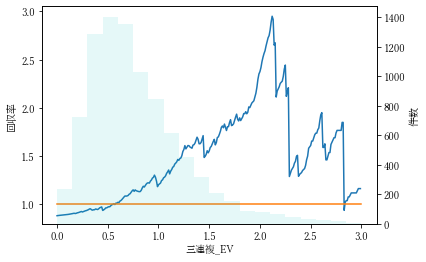

In [227]:
target_col = '三連複'
odds_col = '三連複_odds'
pat = '123'
print('-'*40)
print(target_col, odds_col)
df_use = df_dict[pat].copy().dropna()
df_lb, km = get_wk(pat, 4)
df_use_c = df_use.merge(df_lb, how='left', left_on='race_date', right_index=True)
df_use_c = pd.get_dummies(df_use_c, columns=['label'])

# s_rate, df_train, df_test = get_balanced_data(df_use_c, target_col)
df_train, df_test = train_test_split(df_use_c, stratify=df_use_c[target_col], random_state=0)
X_train = df_train[X_cols]
X_test = df_test[X_cols]
y_train = df_train[target_col]
y_test = df_test[target_col]

clf = LogisticRegression(random_state=0, C=100, class_weight='balanced')
clf.fit(X_train, y_train)
display(pd.Series(clf.coef_[0], X_train.columns).to_frame())

y_pred_prob = clf.predict_proba(df_use_c[X_cols])[:, 1]
# s_rate = 1
s_rate = 0.05
# s_rate = y_train.sum() / len(y_train)
prob2 = y_pred_prob / (y_pred_prob + (1 - y_pred_prob) / s_rate)
pred_col = target_col + '_pred'
df_use[pred_col] = prob2
output_model(clf, target_col, df_use[target_col], prob2, s_rate, X_cols)
print('AUC', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

ev_col = target_col + '_EV'
tmp_odds = '三連複_odds_tmp'
odds_upper = 700
df_use[tmp_odds] = np.where(df_use[odds_col]>odds_upper, odds_upper, df_use[odds_col])
df_use[ev_col] = df_use[pred_col] * df_use[tmp_odds]
# df_use[ev_col] = np.where(df_use[pred_col] < 0.06, 0, df_use[pred_col]) * df_use[odds_col]
# df_use[ev_col] = df_use[pred_col] * df_use[odds_col]
df_ret, max_th = get_return(df_use, ev_col, tmp_odds, target_col ,vmax=min(df_use[ev_col].max(), 3), step=0.01, over=True, plot_min=0.8)
pred_dict[pat] = df_use
km_dict[pat] = km

In [228]:
df_th.loc[pat] = [
    df_ret.query('回収率>=1').index[0],
    df_ret.query('回収率>=1').対象率.values[0],
    df_ret.query('回収率>=1.2').index[0],
    df_ret.query('回収率>=1.2').対象率.values[0],
    df_ret.query('回収率>=1.5').index[0],
    df_ret.query('回収率>=1.5').対象率.values[0],
    df_ret.query('回収率>=1.7').index[0],
    df_ret.query('回収率>=1.7').対象率.values[0]
]
df_th

,ret100_th,ret100_rate,ret120_th,ret120_rate,ret150_th,ret150_rate,ret170_th,ret170_rate
123,0.56,0.638326,0.88,0.345511,1.23,0.159858,1.44,0.098860
124,0.80,0.565925,1.07,0.384147,1.52,0.195395,1.64,0.165061
125,0.38,0.867597,1.01,0.563157,1.51,0.361342,1.89,0.243109
134,0.72,0.769512,1.34,0.470165,2.15,0.244880,2.48,0.184435
135,0.49,0.834939,1.07,0.590723,1.78,0.376840,2.43,0.242223
145,0.88,0.781025,1.43,0.588952,3.01,0.263146,3.29,0.229381
234,0.66,0.750249,1.29,0.535481,2.12,0.352928,2.79,0.257390


### 124

In [229]:
X_cols = [
    'score1',
    'score2',
    'score3',
    'score4',
    'score5',
    'score6',
    'score_ss1',
    'score_ss2',
    'score_ss3',
    'score_ss4',
    'score_ss5',
    'score_ss6',
    'odds1',
    'odds2',
    'odds3',
    'odds4',
#     'odds5',
#     'odds6',
#     's_diff_12',
    's_diff_13',
    's_diff_14',
    's_diff_15',
    's_diff_16',
    's_diff_23',
    's_diff_24',
    's_diff_25',
    's_diff_26',
    's_diff_34',
    's_diff_35',
    's_diff_36',
    's_diff_45',
    's_diff_46',
#     's_diff_56',
#     'race_date',
#  'score_allsum',
#     '三連複_odds',
    'ss_mean',
    'score_sum',
    'score_rate',
    'score_diff',
    'race_class_prize_1勝クラス',
    'race_class_prize_2勝クラス',
    'race_class_prize_3勝クラス',
    'race_class_prize_未勝利',
    'condition_int_1',
    'condition_int_2',
    'condition_int_3',
    'weather_int_1',
    'weather_int_2',
    'weather_int_3',
    'label_0', 
    'label_1',
    'label_2',
    'label_3'
]

三連複 三連複_odds


,0
score1,0.250195
score2,0.234573
score3,0.018712
score4,0.130356
score5,0.042308
score6,0.035923
score_ss1,-0.301223
score_ss2,-0.123913
score_ss3,-0.404056
score_ss4,0.176626


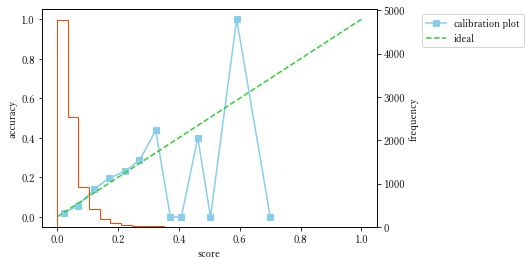

AUC 0.7516856289994945
対象カラム: 三連複_EV, 最大回収率: 3.1809, 閾値: 2.88, 対象数: 251, 対象率: 0.028


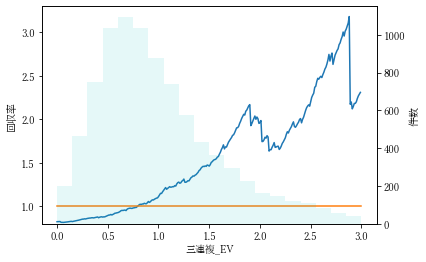

In [230]:
target_col = '三連複'
odds_col = '三連複_odds'
pat = '124'
print(target_col, odds_col)
df_use = df_dict[pat].copy().dropna()
df_lb, km = get_wk(pat, 4)
df_use_c = df_use.merge(df_lb, how='left', left_on='race_date', right_index=True)
df_use_c = pd.get_dummies(df_use_c, columns=['label'])

# s_rate, df_train, df_test = get_balanced_data(df_use_c, target_col)
df_train, df_test = train_test_split(df_use_c, stratify=df_use_c[target_col], random_state=0)
X_train = df_train[X_cols]
X_test = df_test[X_cols]
y_train = df_train[target_col]
y_test = df_test[target_col]

clf = LogisticRegression(random_state=0, C=100, class_weight='balanced')
clf.fit(X_train, y_train)
display(pd.Series(clf.coef_[0], X_train.columns).to_frame())

y_pred_prob = clf.predict_proba(df_use_c[X_cols])[:, 1]
# s_rate = 1
s_rate = 0.05
# s_rate = y_train.sum() / len(y_train)
prob2 = y_pred_prob / (y_pred_prob + (1 - y_pred_prob) / s_rate)
pred_col = target_col + '_pred'
df_use[pred_col] = prob2
output_model(clf, target_col, df_use[target_col], prob2, s_rate, X_cols)
print('AUC', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

ev_col = target_col + '_EV'
tmp_odds = '三連複_odds_tmp'
odds_upper = 700
df_use[tmp_odds] = np.where(df_use[odds_col]>odds_upper, odds_upper, df_use[odds_col])
df_use[ev_col] = df_use[pred_col] * df_use[tmp_odds]
# df_use[ev_col] = np.where(df_use[pred_col] < 0.06, 0, df_use[pred_col]) * df_use[odds_col]
# df_use[ev_col] = df_use[pred_col] * df_use[odds_col]
df_ret, max_th = get_return(df_use, ev_col, tmp_odds, target_col ,vmax=min(df_use[ev_col].max(), 3), step=0.01, over=True, plot_min=0.8)
pred_dict[pat] = df_use
km_dict[pat] = km

In [231]:
df_th.loc[pat] = [
    df_ret.query('回収率>=1').index[0],
    df_ret.query('回収率>=1').対象率.values[0],
    df_ret.query('回収率>=1.2').index[0],
    df_ret.query('回収率>=1.2').対象率.values[0],
    df_ret.query('回収率>=1.5').index[0],
    df_ret.query('回収率>=1.5').対象率.values[0],
    df_ret.query('回収率>=1.7').index[0],
    df_ret.query('回収率>=1.7').対象率.values[0]
]
df_th

,ret100_th,ret100_rate,ret120_th,ret120_rate,ret150_th,ret150_rate,ret170_th,ret170_rate
123,0.56,0.638326,0.88,0.345511,1.23,0.159858,1.44,0.098860
124,0.80,0.565925,1.07,0.384147,1.52,0.195395,1.64,0.165061
125,0.38,0.867597,1.01,0.563157,1.51,0.361342,1.89,0.243109
134,0.72,0.769512,1.34,0.470165,2.15,0.244880,2.48,0.184435
135,0.49,0.834939,1.07,0.590723,1.78,0.376840,2.43,0.242223
145,0.88,0.781025,1.43,0.588952,3.01,0.263146,3.29,0.229381
234,0.66,0.750249,1.29,0.535481,2.12,0.352928,2.79,0.257390


### 125

In [232]:
X_cols = [
    'score1',
    'score2',
    'score3',
    'score4',
    'score5',
    'score6',
    'score_ss1',
    'score_ss2',
    'score_ss3',
    'score_ss4',
    'score_ss5',
    'score_ss6',
    'odds1',
    'odds2',
#     'odds3',
#     'odds4',
    'odds5',
#     'odds6',
    's_diff_12',
    's_diff_13',
    's_diff_14',
    's_diff_15',
    's_diff_16',
    's_diff_23',
#     's_diff_24',
#     's_diff_25',
    's_diff_26',
    's_diff_34',
    's_diff_35',
    's_diff_36',
#     's_diff_45',
    's_diff_46',
    's_diff_56',
#     'race_date',
#  'score_allsum',
#     '三連複_odds',
    'ss_mean',
    'score_sum',
    'score_rate',
    'score_diff',
    'race_class_prize_1勝クラス',
    'race_class_prize_2勝クラス',
    'race_class_prize_3勝クラス',
    'race_class_prize_未勝利',
    'condition_int_1',
    'condition_int_2',
    'condition_int_3',
    'weather_int_1',
    'weather_int_2',
    'weather_int_3',
    'label_0', 
    'label_1',
    'label_2',
    'label_3'
]

三連複 三連複_odds


,0
score1,-0.133608
score2,0.232639
score3,0.423226
score4,0.251379
score5,0.251378
score6,0.075783
score_ss1,0.145767
score_ss2,-0.246626
score_ss3,-0.483980
score_ss4,-0.351822


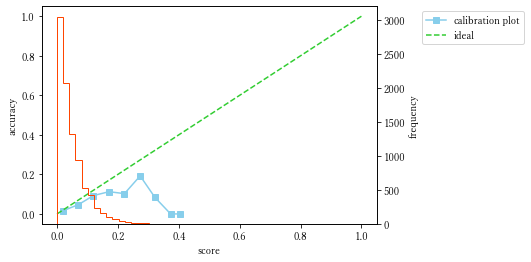

AUC 0.7040544240360922
対象カラム: 三連複_EV, 最大回収率: 3.0944, 閾値: 3.94, 対象数: 284, 対象率: 0.031


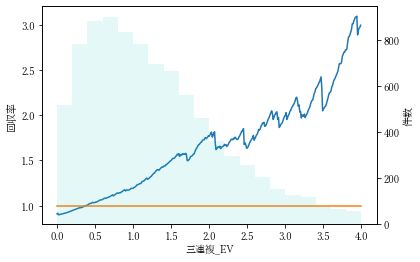

In [234]:
target_col = '三連複'
odds_col = '三連複_odds'
pat = '125'
print(target_col, odds_col)
df_use = df_dict[pat].copy().dropna()
df_lb, km = get_wk(pat, 4)
df_use_c = df_use.merge(df_lb, how='left', left_on='race_date', right_index=True)
df_use_c = pd.get_dummies(df_use_c, columns=['label'])

# s_rate, df_train, df_test = get_balanced_data(df_use_c, target_col)
df_train, df_test = train_test_split(df_use_c, stratify=df_use_c[target_col], random_state=0)
X_train = df_train[X_cols]
X_test = df_test[X_cols]
y_train = df_train[target_col]
y_test = df_test[target_col]

clf = LogisticRegression(random_state=0, C=100, class_weight='balanced')
clf.fit(X_train, y_train)
display(pd.Series(clf.coef_[0], X_train.columns).to_frame())

y_pred_prob = clf.predict_proba(df_use_c[X_cols])[:, 1]
# s_rate = 1
s_rate = 0.05
# s_rate = y_train.sum() / len(y_train)
prob2 = y_pred_prob / (y_pred_prob + (1 - y_pred_prob) / s_rate)
pred_col = target_col + '_pred'
df_use[pred_col] = prob2
output_model(clf, target_col, df_use[target_col], prob2, s_rate, X_cols)
print('AUC', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

ev_col = target_col + '_EV'
tmp_odds = '三連複_odds_tmp'
odds_upper = 700
df_use[tmp_odds] = np.where(df_use[odds_col]>odds_upper, odds_upper, df_use[odds_col])
df_use[ev_col] = df_use[pred_col] * df_use[tmp_odds]
# df_use[ev_col] = np.where(df_use[pred_col] < 0.06, 0, df_use[pred_col]) * df_use[odds_col]
# df_use[ev_col] = df_use[pred_col] * df_use[odds_col]
df_ret, max_th = get_return(df_use, ev_col, tmp_odds, target_col ,vmax=min(df_use[ev_col].max(), 4), step=0.01, over=True, plot_min=0.8)
pred_dict[pat] = df_use
km_dict[pat] = km

In [235]:
df_th.loc[pat] = [
    df_ret.query('回収率>=1').index[0],
    df_ret.query('回収率>=1').対象率.values[0],
    df_ret.query('回収率>=1.2').index[0],
    df_ret.query('回収率>=1.2').対象率.values[0],
    df_ret.query('回収率>=1.5').index[0],
    df_ret.query('回収率>=1.5').対象率.values[0],
    df_ret.query('回収率>=1.7').index[0],
    df_ret.query('回収率>=1.7').対象率.values[0]
]
df_th

,ret100_th,ret100_rate,ret120_th,ret120_rate,ret150_th,ret150_rate,ret170_th,ret170_rate
123,0.56,0.638326,0.88,0.345511,1.23,0.159858,1.44,0.098860
124,0.80,0.565925,1.07,0.384147,1.52,0.195395,1.64,0.165061
125,0.38,0.867597,1.01,0.563157,1.51,0.361342,1.89,0.243109
134,0.72,0.769512,1.34,0.470165,2.15,0.244880,2.48,0.184435
135,0.49,0.834939,1.07,0.590723,1.78,0.376840,2.43,0.242223
145,0.88,0.781025,1.43,0.588952,3.01,0.263146,3.29,0.229381
234,0.66,0.750249,1.29,0.535481,2.12,0.352928,2.79,0.257390


### 134


In [236]:
X_cols = [
    'score1',
    'score2',
    'score3',
    'score4',
#     'score5',
    'score6',
    'score_ss1',
    'score_ss2',
    'score_ss3',
    'score_ss4',
    'score_ss5',
    'score_ss6',
    'odds1',
    'odds2',
    'odds3',
    'odds4',
#     'odds5',
#     'odds6',
#     's_diff_12',
    's_diff_13',
    's_diff_14',
    's_diff_15',
    's_diff_16',
    's_diff_23',
#     's_diff_24',
    's_diff_25',
    's_diff_26',
    's_diff_34',
    's_diff_35',
    's_diff_36',
    's_diff_45',
    's_diff_46',
#     's_diff_56',
#     'race_date',
#  'score_allsum',
#     '三連複_odds',
    'ss_mean',
    'score_sum',
    'score_rate',
    'score_diff',
    'race_class_prize_1勝クラス',
    'race_class_prize_2勝クラス',
    'race_class_prize_3勝クラス',
    'race_class_prize_未勝利',
#     'condition_int_1',
    'condition_int_2',
    'condition_int_3',
#     'weather_int_1',
    'weather_int_2',
    'weather_int_3',
    'label_0', 
    'label_1',
    'label_2',
    'label_3'
]

三連複 三連複_odds


,0
score1,0.320175
score2,0.269544
score3,0.295720
score4,0.270516
score6,0.176746
score_ss1,-0.136855
score_ss2,0.060090
score_ss3,0.289972
score_ss4,-0.271647
score_ss5,-0.386031


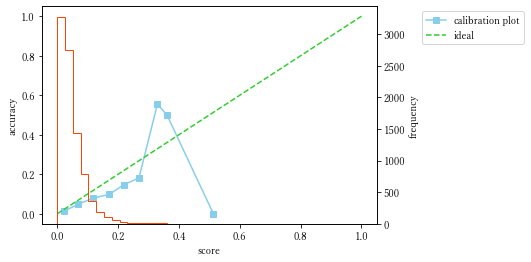

AUC 0.7235690192342353
対象カラム: 三連複_EV, 最大回収率: 3.1662, 閾値: 4.69, 対象数: 337, 対象率: 0.037


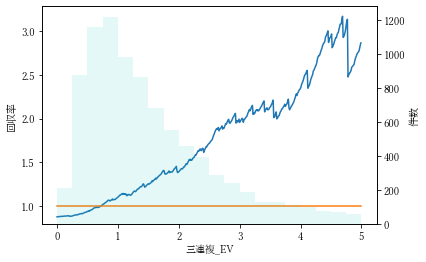

In [237]:
target_col = '三連複'
odds_col = '三連複_odds'
pat = '134'
print(target_col, odds_col)
df_use = df_dict[pat].copy().dropna()
df_lb, km = get_wk(pat, 4)
df_use_c = df_use.merge(df_lb, how='left', left_on='race_date', right_index=True)
df_use_c = pd.get_dummies(df_use_c, columns=['label'])

# s_rate, df_train, df_test = get_balanced_data(df_use_c, target_col)
df_train, df_test = train_test_split(df_use_c, stratify=df_use_c[target_col], random_state=0)
X_train = df_train[X_cols]
X_test = df_test[X_cols]
y_train = df_train[target_col]
y_test = df_test[target_col]

clf = LogisticRegression(random_state=0, C=100, class_weight='balanced')
clf.fit(X_train, y_train)
display(pd.Series(clf.coef_[0], X_train.columns).to_frame())

y_pred_prob = clf.predict_proba(df_use_c[X_cols])[:, 1]
# s_rate = 1
s_rate = 0.05
# s_rate = y_train.sum() / len(y_train)
prob2 = y_pred_prob / (y_pred_prob + (1 - y_pred_prob) / s_rate)
pred_col = target_col + '_pred'
df_use[pred_col] = prob2
output_model(clf, target_col, df_use[target_col], prob2, s_rate, X_cols)
print('AUC', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

ev_col = target_col + '_EV'
tmp_odds = '三連複_odds_tmp'
odds_upper = 700
df_use[tmp_odds] = np.where(df_use[odds_col]>odds_upper, odds_upper, df_use[odds_col])
df_use[ev_col] = df_use[pred_col] * df_use[tmp_odds]
# df_use[ev_col] = np.where(df_use[pred_col] < 0.06, 0, df_use[pred_col]) * df_use[odds_col]
# df_use[ev_col] = df_use[pred_col] * df_use[odds_col]
df_ret, max_th = get_return(df_use, ev_col, tmp_odds, target_col ,vmax=min(df_use[ev_col].max(), 5), step=0.01, over=True, plot_min=0.8)
pred_dict[pat] = df_use
km_dict[pat] = km

In [238]:
df_th.loc[pat] = [
    df_ret.query('回収率>=1').index[0],
    df_ret.query('回収率>=1').対象率.values[0],
    df_ret.query('回収率>=1.2').index[0],
    df_ret.query('回収率>=1.2').対象率.values[0],
    df_ret.query('回収率>=1.5').index[0],
    df_ret.query('回収率>=1.5').対象率.values[0],
    df_ret.query('回収率>=1.7').index[0],
    df_ret.query('回収率>=1.7').対象率.values[0]
]
df_th

,ret100_th,ret100_rate,ret120_th,ret120_rate,ret150_th,ret150_rate,ret170_th,ret170_rate
123,0.56,0.638326,0.88,0.345511,1.23,0.159858,1.44,0.098860
124,0.80,0.565925,1.07,0.384147,1.52,0.195395,1.64,0.165061
125,0.38,0.867597,1.01,0.563157,1.51,0.361342,1.89,0.243109
134,0.72,0.769512,1.34,0.470165,2.15,0.244880,2.48,0.184435
135,0.49,0.834939,1.07,0.590723,1.78,0.376840,2.43,0.242223
145,0.88,0.781025,1.43,0.588952,3.01,0.263146,3.29,0.229381
234,0.66,0.750249,1.29,0.535481,2.12,0.352928,2.79,0.257390


### 135

In [239]:
X_cols = [
    'score1',
    'score2',
    'score3',
    'score4',
    'score5',
#     'score6',
    'score_ss1',
    'score_ss2',
    'score_ss3',
    'score_ss4',
    'score_ss5',
    'score_ss6',
    'odds1',
    'odds2',
    'odds3',
#     'odds4',
    'odds5',
#     'odds6',
    's_diff_12',
    's_diff_13',
    's_diff_14',
    's_diff_15',
    's_diff_16',
    's_diff_23',
    's_diff_24',
    's_diff_25',
    's_diff_26',
    's_diff_34',
    's_diff_35',
    's_diff_36',
    's_diff_45',
    's_diff_46',
    's_diff_56',
#     'race_date',
#  'score_allsum',
#     '三連複_odds',
    'ss_mean',
    'score_sum',
    'score_rate',
    'score_diff',
    'race_class_prize_1勝クラス',
    'race_class_prize_2勝クラス',
    'race_class_prize_3勝クラス',
    'race_class_prize_未勝利',
    'condition_int_1',
    'condition_int_2',
    'condition_int_3',
    'weather_int_1',
    'weather_int_2',
    'weather_int_3',
    'label_0', 
    'label_1',
    'label_2',
    'label_3'
]

三連複 三連複_odds


,0
score1,0.224346
score2,0.155665
score3,0.255920
score4,0.066658
score5,0.136351
score_ss1,-0.284756
score_ss2,-0.429111
score_ss3,0.458656
score_ss4,-0.126946
score_ss5,0.177882


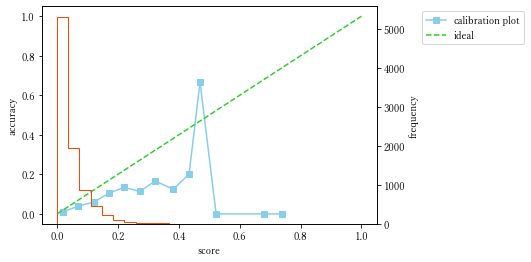

AUC 0.6996040257383269
対象カラム: 三連複_EV, 最大回収率: 3.0007, 閾値: 4.99, 対象数: 438, 対象率: 0.048


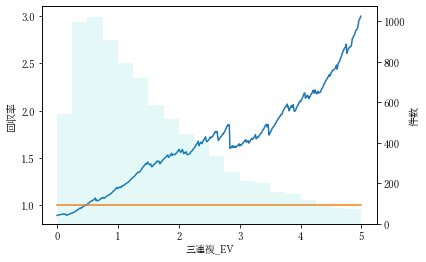

In [240]:
target_col = '三連複'
odds_col = '三連複_odds'
pat = '135'
print(target_col, odds_col)
df_use = df_dict[pat].copy().dropna()
df_lb, km = get_wk(pat, 4)
df_use_c = df_use.merge(df_lb, how='left', left_on='race_date', right_index=True)
df_use_c = pd.get_dummies(df_use_c, columns=['label'])

# s_rate, df_train, df_test = get_balanced_data(df_use_c, target_col)
df_train, df_test = train_test_split(df_use_c, stratify=df_use_c[target_col], random_state=0)
X_train = df_train[X_cols]
X_test = df_test[X_cols]
y_train = df_train[target_col]
y_test = df_test[target_col]

clf = LogisticRegression(random_state=0, C=100, class_weight='balanced')
clf.fit(X_train, y_train)
display(pd.Series(clf.coef_[0], X_train.columns).to_frame())

y_pred_prob = clf.predict_proba(df_use_c[X_cols])[:, 1]
# s_rate = 1
s_rate = 0.05
# s_rate = y_train.sum() / len(y_train)
prob2 = y_pred_prob / (y_pred_prob + (1 - y_pred_prob) / s_rate)
pred_col = target_col + '_pred'
df_use[pred_col] = prob2
output_model(clf, target_col, df_use[target_col], prob2, s_rate, X_cols)
print('AUC', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

ev_col = target_col + '_EV'
tmp_odds = '三連複_odds_tmp'
odds_upper = 700
df_use[tmp_odds] = np.where(df_use[odds_col]>odds_upper, odds_upper, df_use[odds_col])
df_use[ev_col] = df_use[pred_col] * df_use[tmp_odds]
# df_use[ev_col] = np.where(df_use[pred_col] < 0.06, 0, df_use[pred_col]) * df_use[odds_col]
# df_use[ev_col] = df_use[pred_col] * df_use[odds_col]
df_ret, max_th = get_return(df_use, ev_col, tmp_odds, target_col ,vmax=min(df_use[ev_col].max(), 5), step=0.01, over=True, plot_min=0.8)
pred_dict[pat] = df_use
km_dict[pat] = km

In [241]:
df_th.loc[pat] = [
    df_ret.query('回収率>=1').index[0],
    df_ret.query('回収率>=1').対象率.values[0],
    df_ret.query('回収率>=1.2').index[0],
    df_ret.query('回収率>=1.2').対象率.values[0],
    df_ret.query('回収率>=1.5').index[0],
    df_ret.query('回収率>=1.5').対象率.values[0],
    df_ret.query('回収率>=1.7').index[0],
    df_ret.query('回収率>=1.7').対象率.values[0]
]
df_th

,ret100_th,ret100_rate,ret120_th,ret120_rate,ret150_th,ret150_rate,ret170_th,ret170_rate
123,0.56,0.638326,0.88,0.345511,1.23,0.159858,1.44,0.098860
124,0.80,0.565925,1.07,0.384147,1.52,0.195395,1.64,0.165061
125,0.38,0.867597,1.01,0.563157,1.51,0.361342,1.89,0.243109
134,0.72,0.769512,1.34,0.470165,2.15,0.244880,2.48,0.184435
135,0.49,0.834939,1.07,0.590723,1.78,0.376840,2.43,0.242223
145,0.88,0.781025,1.43,0.588952,3.01,0.263146,3.29,0.229381
234,0.66,0.750249,1.29,0.535481,2.12,0.352928,2.79,0.257390


### 145

In [242]:
X_cols = [
    'score1',
    'score2',
    'score3',
    'score4',
    'score5',
    'score6',
    'score_ss1',
    'score_ss2',
    'score_ss3',
    'score_ss4',
    'score_ss5',
    'score_ss6',
    'odds1',
    'odds2',
    'odds3',
    'odds4',
    'odds5',
#     'odds6',
    's_diff_12',
    's_diff_13',
    's_diff_14',
    's_diff_15',
    's_diff_16',
#     's_diff_23',
    's_diff_24',
    's_diff_25',
    's_diff_26',
    's_diff_34',
    's_diff_35',
#     's_diff_36',
    's_diff_45',
#     's_diff_46',
    's_diff_56',
#     'race_date',
#  'score_allsum',
#     '三連複_odds',
    'ss_mean',
    'score_sum',
    'score_rate',
    'score_diff',
    'race_class_prize_1勝クラス',
#     'race_class_prize_2勝クラス',
    'race_class_prize_3勝クラス',
    'race_class_prize_未勝利',
    'condition_int_1',
    'condition_int_2',
    'condition_int_3',
    'weather_int_1',
    'weather_int_2',
    'weather_int_3',
    'label_0', 
    'label_1',
    'label_2',
    'label_3'
]

三連複 三連複_odds


,0
score1,0.231528
score2,0.139775
score3,0.127383
score4,0.073818
score5,0.039619
score6,0.084840
score_ss1,-0.144242
score_ss2,-0.296384
score_ss3,-0.037561
score_ss4,-0.004274


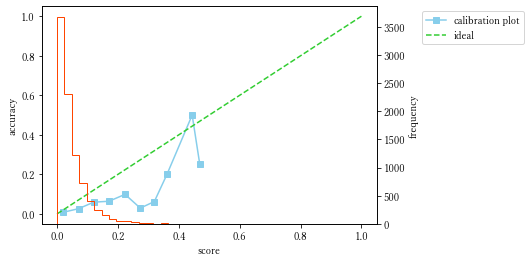

AUC 0.795735034841743
対象カラム: 三連複_EV, 最大回収率: 2.6284, 閾値: 4.93, 対象数: 927, 対象率: 0.103


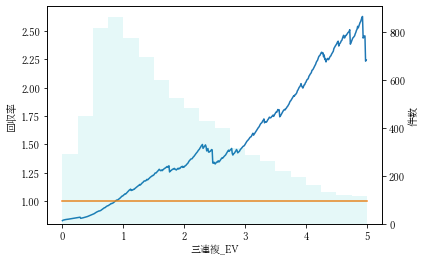

In [243]:
target_col = '三連複'
odds_col = '三連複_odds'
pat = '145'
print(target_col, odds_col)
df_use = df_dict[pat].copy().dropna()
df_lb, km = get_wk(pat, 4)
df_use_c = df_use.merge(df_lb, how='left', left_on='race_date', right_index=True)
df_use_c = pd.get_dummies(df_use_c, columns=['label'])

# s_rate, df_train, df_test = get_balanced_data(df_use_c, target_col)
df_train, df_test = train_test_split(df_use_c, stratify=df_use_c[target_col], random_state=0)
X_train = df_train[X_cols]
X_test = df_test[X_cols]
y_train = df_train[target_col]
y_test = df_test[target_col]

clf = LogisticRegression(random_state=0, C=100, class_weight='balanced')
clf.fit(X_train, y_train)
display(pd.Series(clf.coef_[0], X_train.columns).to_frame())

y_pred_prob = clf.predict_proba(df_use_c[X_cols])[:, 1]
# s_rate = 1
s_rate = 0.05
# s_rate = y_train.sum() / len(y_train)
prob2 = y_pred_prob / (y_pred_prob + (1 - y_pred_prob) / s_rate)
pred_col = target_col + '_pred'
df_use[pred_col] = prob2
output_model(clf, target_col, df_use[target_col], prob2, s_rate, X_cols)
print('AUC', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

ev_col = target_col + '_EV'
tmp_odds = '三連複_odds_tmp'
odds_upper = 700
df_use[tmp_odds] = np.where(df_use[odds_col]>odds_upper, odds_upper, df_use[odds_col])
df_use[ev_col] = df_use[pred_col] * df_use[tmp_odds]
# df_use[ev_col] = np.where(df_use[pred_col] < 0.06, 0, df_use[pred_col]) * df_use[odds_col]
# df_use[ev_col] = df_use[pred_col] * df_use[odds_col]
df_ret, max_th = get_return(df_use, ev_col, tmp_odds, target_col ,vmax=min(df_use[ev_col].max(), 5), step=0.01, over=True, plot_min=0.8)
pred_dict[pat] = df_use
km_dict[pat] = km

In [244]:
df_th.loc[pat] = [
    df_ret.query('回収率>=1').index[0],
    df_ret.query('回収率>=1').対象率.values[0],
    df_ret.query('回収率>=1.2').index[0],
    df_ret.query('回収率>=1.2').対象率.values[0],
    df_ret.query('回収率>=1.5').index[0],
    df_ret.query('回収率>=1.5').対象率.values[0],
    df_ret.query('回収率>=1.7').index[0],
    df_ret.query('回収率>=1.7').対象率.values[0]
]
df_th

,ret100_th,ret100_rate,ret120_th,ret120_rate,ret150_th,ret150_rate,ret170_th,ret170_rate
123,0.56,0.638326,0.88,0.345511,1.23,0.159858,1.44,0.098860
124,0.80,0.565925,1.07,0.384147,1.52,0.195395,1.64,0.165061
125,0.38,0.867597,1.01,0.563157,1.51,0.361342,1.89,0.243109
134,0.72,0.769512,1.34,0.470165,2.15,0.244880,2.48,0.184435
135,0.49,0.834939,1.07,0.590723,1.78,0.376840,2.43,0.242223
145,0.88,0.781025,1.43,0.588952,3.01,0.263146,3.29,0.229381
234,0.66,0.750249,1.29,0.535481,2.12,0.352928,2.79,0.257390


### 234

In [245]:
X_cols = [
    'score1',
    'score2',
    'score3',
    'score4',
    'score5',
    'score6',
    'score_ss1',
    'score_ss2',
    'score_ss3',
    'score_ss4',
    'score_ss5',
    'score_ss6',
    'odds1',
    'odds2',
    'odds3',
    'odds4',
#     'odds5',
#     'odds6',
    's_diff_12',
    's_diff_13',
    's_diff_14',
#     's_diff_15',
#     's_diff_16',
#     's_diff_23',
#     's_diff_24',
    's_diff_25',
    's_diff_26',
#     's_diff_34',
    's_diff_35',
    's_diff_36',
    's_diff_45',
    's_diff_46',
#     's_diff_56',
#     'race_date',
#  'score_allsum',
#     '三連複_odds',
    'ss_mean',
    'score_sum',
    'score_rate',
    'score_diff',
    'race_class_prize_1勝クラス',
    'race_class_prize_2勝クラス',
    'race_class_prize_3勝クラス',
    'race_class_prize_未勝利',
    'condition_int_1',
    'condition_int_2',
    'condition_int_3',
    'weather_int_1',
    'weather_int_2',
    'weather_int_3',
    'label_0', 
    'label_1',
    'label_2',
    'label_3'
]

三連複 三連複_odds


,0
score1,0.264595
score2,0.218505
score3,0.374341
score4,-0.066477
score5,-0.115421
score6,0.075076
score_ss1,-0.536726
score_ss2,-0.495284
score_ss3,0.342977
score_ss4,-0.169038


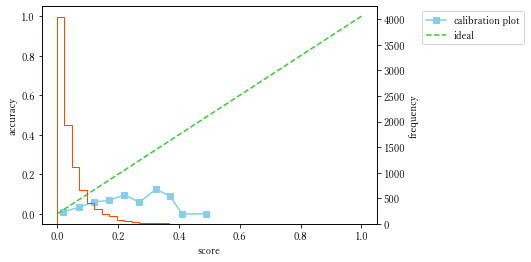

AUC 0.7555875923413236
対象カラム: 三連複_EV, 最大回収率: 2.2072, 閾値: 4.65, 対象数: 1031, 対象率: 0.114


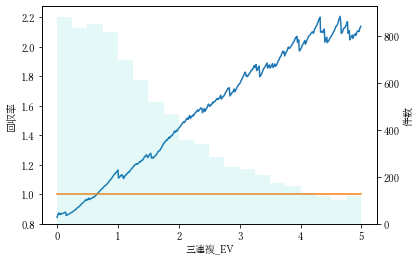

In [246]:
target_col = '三連複'
odds_col = '三連複_odds'
pat = '234'
print(target_col, odds_col)
df_use = df_dict[pat].copy().dropna()
df_lb, km = get_wk(pat, 4)
df_use_c = df_use.merge(df_lb, how='left', left_on='race_date', right_index=True)
df_use_c = pd.get_dummies(df_use_c, columns=['label'])

# s_rate, df_train, df_test = get_balanced_data(df_use_c, target_col)
df_train, df_test = train_test_split(df_use_c, stratify=df_use_c[target_col], random_state=0)
X_train = df_train[X_cols]
X_test = df_test[X_cols]
y_train = df_train[target_col]
y_test = df_test[target_col]

clf = LogisticRegression(random_state=0, C=100, class_weight='balanced')
clf.fit(X_train, y_train)
display(pd.Series(clf.coef_[0], X_train.columns).to_frame())

y_pred_prob = clf.predict_proba(df_use_c[X_cols])[:, 1]
# s_rate = 1
s_rate = 0.05
# s_rate = y_train.sum() / len(y_train)
prob2 = y_pred_prob / (y_pred_prob + (1 - y_pred_prob) / s_rate)
pred_col = target_col + '_pred'
df_use[pred_col] = prob2
output_model(clf, target_col, df_use[target_col], prob2, s_rate, X_cols)
print('AUC', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

ev_col = target_col + '_EV'
tmp_odds = '三連複_odds_tmp'
odds_upper = 700
df_use[tmp_odds] = np.where(df_use[odds_col]>odds_upper, odds_upper, df_use[odds_col])
df_use[ev_col] = df_use[pred_col] * df_use[tmp_odds]
# df_use[ev_col] = np.where(df_use[pred_col] < 0.06, 0, df_use[pred_col]) * df_use[odds_col]
# df_use[ev_col] = df_use[pred_col] * df_use[odds_col]
df_ret, max_th = get_return(df_use, ev_col, tmp_odds, target_col ,vmax=min(df_use[ev_col].max(), 5), step=0.01, over=True, plot_min=0.8)
pred_dict[pat] = df_use
km_dict[pat] = km

In [247]:
df_th.loc[pat] = [
    df_ret.query('回収率>=1').index[0],
    df_ret.query('回収率>=1').対象率.values[0],
    df_ret.query('回収率>=1.2').index[0],
    df_ret.query('回収率>=1.2').対象率.values[0],
    df_ret.query('回収率>=1.5').index[0],
    df_ret.query('回収率>=1.5').対象率.values[0],
    df_ret.query('回収率>=1.7').index[0],
    df_ret.query('回収率>=1.7').対象率.values[0]
]
df_th

,ret100_th,ret100_rate,ret120_th,ret120_rate,ret150_th,ret150_rate,ret170_th,ret170_rate
123,0.56,0.638326,0.88,0.345511,1.23,0.159858,1.44,0.098860
124,0.80,0.565925,1.07,0.384147,1.52,0.195395,1.64,0.165061
125,0.38,0.867597,1.01,0.563157,1.51,0.361342,1.89,0.243109
134,0.72,0.769512,1.34,0.470165,2.15,0.244880,2.48,0.184435
135,0.49,0.834939,1.07,0.590723,1.78,0.376840,2.43,0.242223
145,0.88,0.781025,1.43,0.588952,3.01,0.263146,3.29,0.229381
234,0.66,0.750249,1.29,0.535481,2.12,0.352928,2.79,0.257390


# 閾値以上の馬券とは

In [253]:
def add_buy_col(df_use, df_th, target_col='三連複', pat=None):
    
    ev_col = target_col + '_EV'
    for th in ['100', '120', '150', '170']:
        th_col = f'ret{th}_th'
        buy_col = f'{target_col}_{th}_buy'

        df_use[buy_col] = 0
        df_use.loc[df_use[ev_col]>=df_th.loc[pat, th_col], buy_col] = 1
    return df_use

In [254]:
def get_pat_rate(df_ac, df_use, th=170):
    tmp = pd.crosstab(df_ac.pat, df_use[f'三連複_{th}_buy'], margins=True)
    tmp['buy_rate'] = tmp[1] / tmp.All
    tmp['acc_cnt'] = df_use.query(f'(三連複_{th}_buy==1)&(三連複==1)').merge(df_ac[['三連複_key', 'pat']]).pat.value_counts().sort_index()
    tmp['acc_rate'] = tmp['acc_cnt'] / tmp[1]
    return tmp

In [255]:
for k,v in pred_dict.items():
    pred_dict[k] = add_buy_col(v, df_th, pat=k)

In [263]:
df_all = pd.concat(pred_dict.values(), ignore_index=True)

In [264]:
get_pat_rate(df_all, df_all, th=170)

三連複_170_buy,0,1,All,buy_rate,acc_cnt,acc_rate
pat,,,,,,
123,8140,893,9033,0.098860,46.0,0.051512
124,7542,1491,9033,0.165061,56.0,0.037559
125,6837,2196,9033,0.243109,74.0,0.033698
134,7367,1666,9033,0.184435,42.0,0.025210
135,6845,2188,9033,0.242223,75.0,0.034278
145,6961,2072,9033,0.229381,51.0,0.024614
234,6708,2325,9033,0.257390,68.0,0.029247
All,50400,12831,63231,0.202923,NaN,NaN


In [266]:
get_pat_rate(df_all, df_all, th=150)

三連複_150_buy,0,1,All,buy_rate,acc_cnt,acc_rate
pat,,,,,,
123,7589,1444,9033,0.159858,76.0,0.052632
124,7268,1765,9033,0.195395,65.0,0.036827
125,5769,3264,9033,0.361342,120.0,0.036765
134,6821,2212,9033,0.244880,57.0,0.025769
135,5629,3404,9033,0.376840,112.0,0.032902
145,6656,2377,9033,0.263146,52.0,0.021876
234,5845,3188,9033,0.352928,95.0,0.029799
All,45577,17654,63231,0.279198,NaN,NaN


In [267]:
plt.rcParams['font.family'] = 'Yu mincho'
plt.rcParams['figure.dpi'] = 100

In [44]:
income_dict = {}
for y in range(2012, 2020):
    df_tmp = df_use.loc[df_use.race_id.isin(df_info.loc[df_info.race_date.dt.year==y].index)]
    tmp = pd.concat([
        df_tmp.query('(三連複_150_buy==1)').race_date.value_counts(),
        df_tmp.query('(三連複==1) and (三連複_150_buy==1)').groupby('race_date').三連複_odds.sum()
    ], axis=1)
    tmp.columns = ['buy', 'income']
    tmp.sort_index(inplace=True)
    tmp.income.fillna(0, inplace=True)

    tmp['in_diff'] = tmp.income - tmp.buy
    tmp['diff_cumsum'] = tmp.in_diff.cumsum()
    tmp['buy_cumsum'] = tmp.buy.cumsum()
    income_dict[y] = tmp

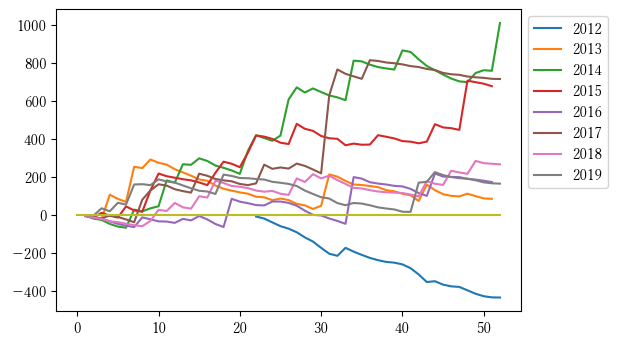

,buy_sum,diff_min,total_in,total_in_rate
2012,533.0,-434.7,-434.7,-0.815572
2013,726.0,-22.0,85.1,0.117218
2014,824.0,-67.0,1010.6,1.226456
2015,724.0,-13.7,678.0,0.936464
2016,626.0,-64.0,173.3,0.276837
2017,591.0,-38.3,715.8,1.211168
2018,550.0,-59.0,266.7,0.484909
2019,557.0,-3.0,164.8,0.295871


In [45]:
df_y = pd.DataFrame(columns=['buy_sum', 'diff_min', 'total_in', 'total_in_rate'])
for k,v in income_dict.items():
    df_y.loc[k] = [
        v.buy.sum(),
        v.diff_cumsum.min(),
        v.tail(1).diff_cumsum.values[0],
        (v.tail(1).diff_cumsum / v.tail(1).buy_cumsum).values[0]
    ]
    v.diff_cumsum.plot()
plt.legend(income_dict.keys(), bbox_to_anchor=(1,1))
plt.plot([0, 52], [0, 0])
plt.show()
display(df_y)

In [46]:
diff_min_max = -100
lot = 1000
total_in = 400

print('必要なお金:  ', diff_min_max*lot)
print('得られるお金: ', lot * total_in)

必要なお金:   -100000
得られるお金:  400000


<AxesSubplot:>

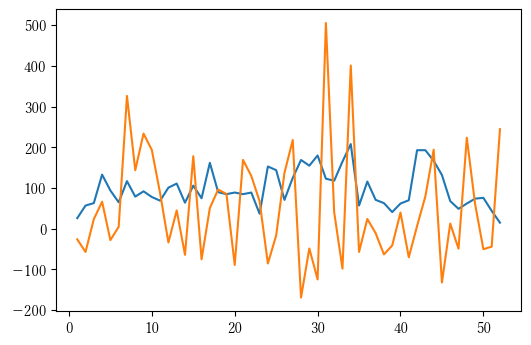

In [47]:
in_diff = pd.concat([v[['in_diff']].rename(columns={'in_diff':k}) for k,v in income_dict.items()], axis=1)
in_diff['total'] = in_diff.sum(axis=1)

buy = pd.concat([v[['buy']].rename(columns={'buy':k}) for k,v in income_dict.items()], axis=1)
buy['total'] = buy.sum(axis=1)

buy.total.plot()
in_diff.total.plot()

# 2020

In [48]:
import pathlib
resource_path = pathlib.Path('../../../resource')
file_score = resource_path / 'common/model/WinHorse/features/wh_score_2020.csv'

df_2020 = pd.read_csv(file_score, index_col=0)
print(df_2020.shape)
df_2020.head(2)

(14685, 3)


,race_id,horse_id,pred_prob
0,202008010105,44406,0.348138
1,202008010105,45743,0.106173


<AxesSubplot:label='919ad622-6b9f-4ded-a6b6-19550cb6515f'>

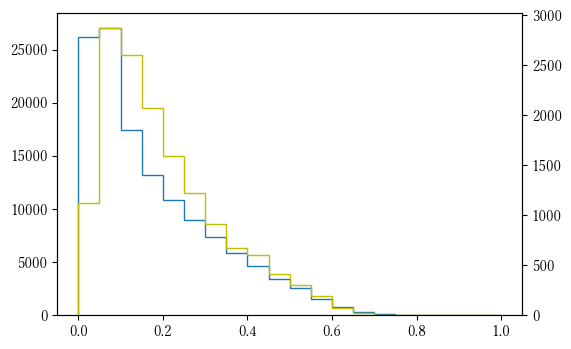

In [49]:
df_pred.pred_prob.hist(bins=20, histtype='step', range=(0,1), grid=False)
plt.twinx()
df_2020.pred_prob.hist(bins=20, histtype='step', range=(0,1), color='y', grid=False)

In [50]:
df_info_2020 = pd.read_csv(resource_path/'scoring/race_info_parsed_2020.csv', usecols=['race_id', 'condition_int', 'weather_int', 'race_class_prize','race_date'])
df_info_2020.race_date = pd.to_datetime(df_info_2020.race_date)
print(df_info_2020.shape)
df_info_2020.head(2)

(3078, 5)


,race_id,race_date,race_class_prize,condition_int,weather_int
0,201910021212,2019-09-01,1勝クラス,3,2
1,202001010101,2020-07-25,未勝利,1,2


In [51]:
df_result_2020 = pd.read_csv(resource_path/'scoring/horse_parsed_2020.csv', usecols=['race_id', 'horse_id','馬名', 'odds', 'arrival', 'course_num'])
print(df_result_2020.shape)
df_result_2020.head(2)

(42690, 6)


,arrival,course_num,馬名,odds,race_id,horse_id
0,1,14,バイマイサイド,4.4,201910021212,10405
1,2,2,ヒラボクメルロー,13.0,201910021212,11251


In [52]:
df_san_2020 = parse_sanrenpuku(resource_path/'common/raw_result/odds/sanrenpuku_new_odds.csv')
print(df_san_2020.shape)
df_san_2020.head(2)

(556873, 7)


,組み合わせ,オッズ,race_id,馬1,馬2,馬3,三連複_key
0,1 2 3,561.7,201910021212,01,02,03,201910021212010203
1,1 2 4,851.2,201910021212,01,02,04,201910021212010204


In [53]:
df_2020 = df_2020.merge(df_result_2020, how='left', on=['race_id', 'horse_id'])
df_2020 = add_ss(df_2020)
df_2020 = get_rank(df_2020)
df_buy = make_buy(df_2020)
df_buy = merge_odds(df_buy, df_san_2020)
df_buy = get_features(df_buy, df_2020)

acc_list = get_acc_ids(df_2020)
df_buy['三連複'] = 0
df_buy.loc[df_buy.三連複_key.isin(acc_list), '三連複'] = 1

df_buy = df_buy.merge(df_info_2020, how='left', on='race_id')
df_buy['race_date'] = df_buy.race_date.dt.week

df_use_2020 = df_buy.loc[df_buy.pat.isin({'123', '124', '125', '134', '135', '145'})].copy().dropna()
df_use_2020 = pd.get_dummies(df_use_2020, columns=['race_class_prize', 'condition_int', 'weather_int', 'pat'])

In [54]:
tmp = pd.crosstab(df_ac.race_class_prize, df_ac.三連複, margins=True)
tmp['ac_rate'] = tmp[1] / tmp.All
tmp

三連複,0,1,All,ac_rate
race_class_prize,,,,
1勝クラス,31768,792,32560,0.024324
2勝クラス,16143,477,16620,0.028700
3勝クラス,7118,172,7290,0.023594
未勝利,34234,1066,35300,0.030198
All,89263,2507,91770,0.027318


In [55]:
tmp = pd.crosstab(df_buy.race_class_prize, df_buy.三連複, margins=True)
tmp['ac_rate'] = tmp[1] / tmp.All
tmp

三連複,0,1,All,ac_rate
race_class_prize,,,,
1勝クラス,3620,90,3710,0.024259
2勝クラス,2058,52,2110,0.024645
3勝クラス,913,17,930,0.018280
未勝利,4041,109,4150,0.026265
All,10632,268,10900,0.024587


In [56]:
target_col = '三連複'
odds_col = '三連複_odds'
df_ft = df_use_2020.copy()
df_ft = df_ft.merge(df_lb, how='left', left_on='race_date', right_index=True)
df_ft = pd.get_dummies(df_ft, columns=['label'])

y_pred_prob = clf.predict_proba(df_ft[X_cols])[:, 1]
# s_rate = 1
s_rate = 0.05
# s_rate = y_train.sum() / len(y_train)
prob2 = y_pred_prob / (y_pred_prob + (1 - y_pred_prob) / s_rate)
pred_col = target_col + '_pred'
df_use_2020[pred_col] = prob2
print('AUC', roc_auc_score(df_use_2020[target_col], df_use_2020[pred_col]))

ev_col = target_col + '_EV'
odds_adjusted = odds_col + '_adjusted'
ev_adjusted = ev_col + '_adjusted'

odds_upper = 700

df_use_2020[odds_adjusted] = np.where(df_use_2020[odds_col]>odds_upper, odds_upper, df_use_2020[odds_col])
df_use_2020[ev_adjusted] = df_use_2020[pred_col] * df_use_2020[odds_adjusted]
df_use_2020[ev_col] = df_use_2020[pred_col] * df_use_2020[odds_col]
# df_ret_tmp, max_th = get_return(
#     df_use_2020,
#     ev_adjusted,
#     odds_adjusted,
#     target_col,
#     vmax=min(df_use_2020[ev_adjusted].max(), 5),
#     step=0.01,
#     over=True,
#     plot_min=0.8
# )

AUC 0.7583240870976365


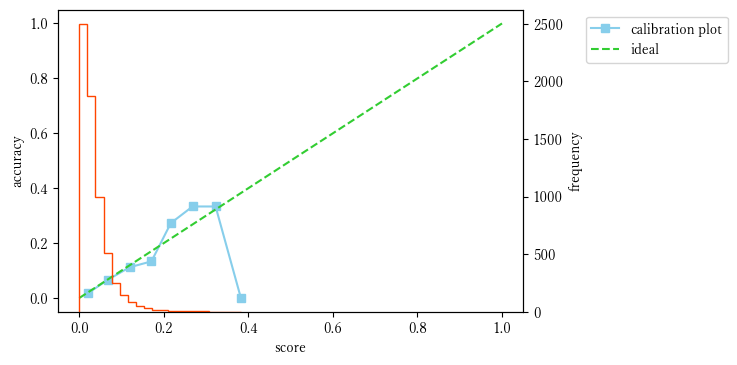

<Figure size 600x400 with 0 Axes>

In [57]:
plot_calibration(df_use_2020.三連複, df_use_2020.三連複_pred)

In [58]:
df_use_2020 = add_buy_col(df_use_2020, df_th)

In [59]:
get_pat_rate(df_buy, df_use_2020, 150)

三連複_150_buy,0,1,All,buy_rate,acc_cnt,acc_rate
pat,,,,,,
123,1027,55,1082,0.050832,1.0,0.018182
124,1038,44,1082,0.040665,NaN,NaN
125,1029,53,1082,0.048983,1.0,0.018868
134,1035,47,1082,0.043438,NaN,NaN
135,1046,36,1082,0.033272,NaN,NaN
145,1037,45,1082,0.041590,NaN,NaN
All,6212,280,6492,0.043130,NaN,NaN


In [61]:
def get_income(df_tmp, th='150'):
    tmp = pd.concat([
        df_tmp.query(f'(三連複_{th}_buy==1)').race_date.value_counts(),
        df_tmp.query(f'(三連複==1) and (三連複_{th}_buy==1)').groupby('race_date').三連複_odds.sum()
    ], axis=1)
    tmp.columns = ['buy', 'income']
    tmp.sort_index(inplace=True)
    tmp.income.fillna(0, inplace=True)

    tmp['in_diff'] = tmp.income - tmp.buy
    tmp['diff_cumsum'] = tmp.in_diff.cumsum()
    tmp['buy_cumsum'] = tmp.buy.cumsum()
    return tmp

In [62]:
get_income(df_use_2020, 150)

,buy,income,in_diff,diff_cumsum,buy_cumsum
1,2,31.8,29.8,29.8,2
3,4,0.0,-4.0,25.8,6
4,18,0.0,-18.0,7.8,24
5,19,0.0,-19.0,-11.2,43
6,3,0.0,-3.0,-14.2,46
7,12,0.0,-12.0,-26.2,58
8,1,0.0,-1.0,-27.2,59
9,8,0.0,-8.0,-35.2,67
10,3,0.0,-3.0,-38.2,70
11,2,0.0,-2.0,-40.2,72


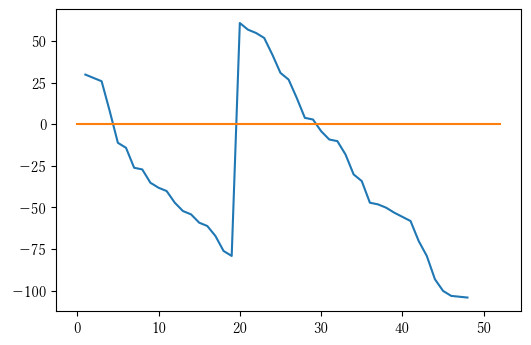

In [63]:
get_income(df_use_2020, 150).diff_cumsum.plot()
plt.plot([0, 52], [0, 0])
plt.show()